In [1]:
import yfinance as yf
import pandas as pd

# Download stock data (NIFTY 50 for India, or S&P 500 for USA)
data = yf.download("^NSEI", start="2015-01-01", end="2025-01-01")  

# Save to CSV so we can reuse it
data.to_csv("nifty_data.csv")

print(data.head())


/tmp/ipykernel_12228/3022064529.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^NSEI", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume
Ticker            ^NSEI        ^NSEI        ^NSEI        ^NSEI   ^NSEI
Date                                                                  
2015-01-02  8395.450195  8410.599609  8288.700195  8288.700195  101900
2015-01-05  8378.400391  8445.599609  8363.900391  8407.950195  118200
2015-01-06  8127.350098  8327.849609  8111.350098  8325.299805  172800
2015-01-07  8102.100098  8151.200195  8065.450195  8118.649902  164100
2015-01-08  8234.599609  8243.500000  8167.299805  8191.399902  143800


In [3]:
import pandas as pd
import numpy as np

# Load data (Date is already the index)
df = pd.read_csv("nifty_data.csv", header=[0,1], index_col=0, parse_dates=True)

# Drop the multi-index (keep only first row of headers, e.g. 'Price', 'Close' etc.)
df.columns = df.columns.get_level_values(0)

# Check data
print(df.head())

# Use 'Close' column for returns
df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))

# Show first few values
print(df[["Close", "LogReturn"]].head())


Price             Close         High          Low         Open  Volume
Date                                                                  
2015-01-02  8395.450195  8410.599609  8288.700195  8288.700195  101900
2015-01-05  8378.400391  8445.599609  8363.900391  8407.950195  118200
2015-01-06  8127.350098  8327.849609  8111.350098  8325.299805  172800
2015-01-07  8102.100098  8151.200195  8065.450195  8118.649902  164100
2015-01-08  8234.599609  8243.500000  8167.299805  8191.399902  143800
Price             Close  LogReturn
Date                              
2015-01-02  8395.450195        NaN
2015-01-05  8378.400391  -0.002033
2015-01-06  8127.350098  -0.030422
2015-01-07  8102.100098  -0.003112
2015-01-08  8234.599609   0.016221


In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Train on 80% data
train_size = int(len(df) * 0.8)
train, test = df["LogReturn"].dropna()[:train_size], df["LogReturn"].dropna()[train_size:]

# Fit ARIMA
model = ARIMA(train, order=(1,0,1))  # (p,d,q)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

print(forecast[:5])


1967    0.000518
1968    0.000374
1969    0.000388
1970    0.000387
1971    0.000387
Name: predicted_mean, dtype: float64


/home/kush/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kush/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kush/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kush/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

In [8]:
import numpy as np
import torch
import torch.nn as nn

# Prepare data
returns = df["LogReturn"].dropna().values
X, y = [], []
for i in range(50, len(returns)):
    X.append(returns[i-50:i])
    y.append(returns[i])
X, y = np.array(X), np.array(y)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32)

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 50, batch_first=True)
        self.fc = nn.Linear(50, 1)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(10):
    optimizer.zero_grad()
    output = model(X)
    loss = loss_fn(output.squeeze(), y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.0002587728959042579
Epoch 2, Loss: 0.00011185858602402732
Epoch 3, Loss: 0.00018551043467596173
Epoch 4, Loss: 0.00019222198170609772
Epoch 5, Loss: 0.00014235101116355509
Epoch 6, Loss: 0.0001120083179557696
Epoch 7, Loss: 0.00012435221287887543
Epoch 8, Loss: 0.00014899087545927614
Epoch 9, Loss: 0.00015157763846218586
Epoch 10, Loss: 0.0001332685787929222


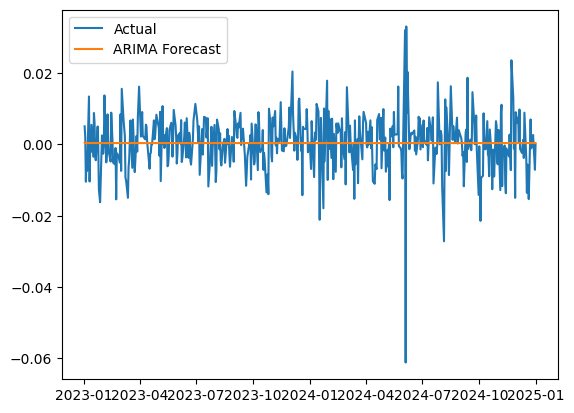

In [10]:
import matplotlib.pyplot as plt

plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="ARIMA Forecast")
plt.legend()
plt.show()


NameError: name 'lstm_forecast' is not defined

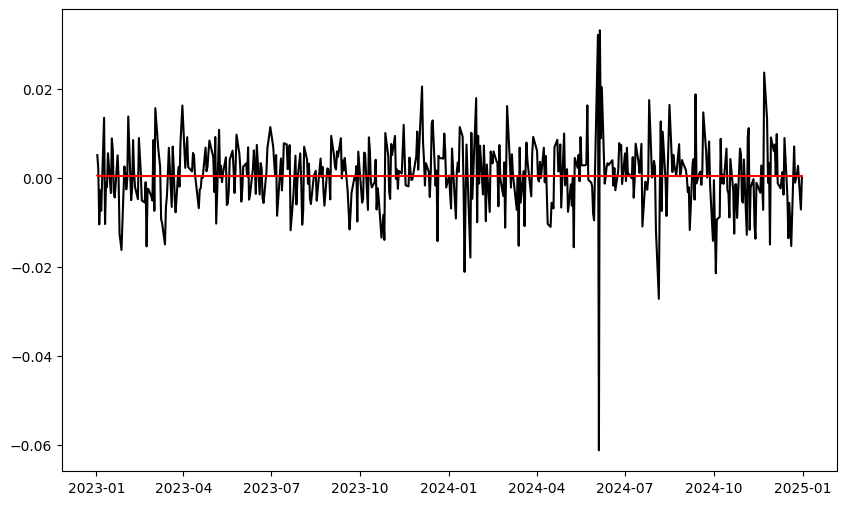

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Actual values
plt.plot(test.index, test, label="Actual", color="black")

# ARIMA forecast
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red")

# LSTM forecast
plt.plot(test.index, lstm_forecast, label="LSTM Forecast", color="blue")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs ARIMA vs LSTM Forecast")
plt.legend()
plt.grid(True)
plt.show()
